# Using Machine Learning To Improve Count-Min Sketches

In [1]:
from sklearn.utils import murmurhash3_32
import random
import sys

random.seed(13)

def h(x, seed, R):
    return murmurhash3_32(key=x, seed=seed) % R

class CountMinSketch:
  def __init__(self, d: int, R: int):
    self.d = d
    self.R = R
    self.array = []

    for _i in range(d):
      self.array.append([0] * R)

  def insert(self, token: str):
    for i in range(self.d):
      hash = h(token, i, self.R)
      self.array[i][hash] += 1

  def query(self, token: str):
    res = []
    for i in range(self.d):
      hash = h(token, i, self.R)
      res.append(self.array[i][hash])
    return min(res)
  
  def get_memory_usage(self):
    memory = sys.getsizeof(self)
    for subarray in self.array:
      memory += sys.getsizeof(subarray)
    return memory

## Oracle Architecture

In [81]:
from collections import defaultdict

from abc import ABC, abstractmethod 
  
class Oracle(ABC): 
  
    @abstractmethod
    def predict_heavy_hitter(self, token): 
        pass

    @abstractmethod
    def get_memory_usage(self): 
        pass

class CountMinSketchWithOracle(CountMinSketch):

  def __init__(self, d: int, R: int, oracle: Oracle):
    super().__init__(d, R)
    self.oracle = oracle
    self.heavy_hitter_counts = {}

  def insert(self, token: str):
    if token in self.heavy_hitter_counts:
      self.heavy_hitter_counts[token] += 1
    elif self.oracle.predict_heavy_hitter(token) == 1:
      self.heavy_hitter_counts[token] = 1
    else:
      super().insert(token)
  
  def fast_insert(self, tokens, is_heavy_hitter):
    for i in range(len(tokens)):
      if is_heavy_hitter[i] == 1:
        if token in self.heavy_hitter_counts:
          self.heavy_hitter_counts[tokens[i]] += 1
        else:
          self.heavy_hitter_counts[tokens[i]] = 1
      else:
        super().insert(tokens[i])

  def query(self, token: str):
    if token in self.heavy_hitter_counts:
      return self.heavy_hitter_counts[token]
    else:
      return super().query(token)
    
  def get_memory_usage(self):
    return super().get_memory_usage() + self.oracle.get_memory_usage() + sys.getsizeof(self.heavy_hitter_counts)

In [82]:
import pandas as pd

queries = []
for i in range(1, 2):
    data = pd.read_csv('data/aol/user-ct-test-collection-0' + str(i) + '.txt', sep="\t")
    queries.extend(data.Query.dropna())

In [67]:
from collections import Counter 

tokens_freq = Counter(queries)

In [68]:
print(len(tokens_freq))

1216652


In [8]:
common_tokens = tokens_freq.most_common(1000)

In [83]:
import math

HEAVY_HITTER_THRESHOLD = sorted(tokens_freq.items(), key = lambda x: x[1], reverse = True)[math.ceil(len(tokens_freq.items()) * 0.01)][1]

In [84]:
D = 3
R_range = range(13, 17)
R_range_oracles = range(12, 17)

In [85]:
all_sketches = {
    "basic": {
        "label": "Count Min Sketch",
        "plot_linestyle": "dashed"
    },
    "ideal": {
        "label": "Learned CMS (Ideal)",
        "plot_linestyle": "dashed"
    },
    # "lr": {
    #     "label": "Learned CMS (Logistic Regression)",
    #     "plot_linestyle": "solid"
    # },
    # "svm": {
    #     "label": "Learned CMS (SVM)",
    #     "plot_linestyle": "solid"
    # },
    # "nn": {
    #     "label": "Learned CMS (Simple NN)",
    #     "plot_linestyle": "solid"
    # }
}

## Basic Count-Min Sketch

In [86]:
all_sketches["basic"]["sketches"] = [CountMinSketch(D, 2 ** R) for R in R_range]

In [87]:
for query in queries:
    for sketch in all_sketches["basic"]["sketches"]:
        sketch.insert(query)

## Ideal Oracle (For Benchmarking)

In [88]:
class IdealOracle(Oracle): 
  
    def predict_heavy_hitter(self, token): 
        if token in tokens_freq and tokens_freq[token] >= HEAVY_HITTER_THRESHOLD:
            return 1
        else: 
            return 0

    def get_memory_usage(self): 
        return 0

ideal_oracle = IdealOracle()
all_sketches["ideal"]["sketches"] = [CountMinSketchWithOracle(D, 2 ** R, ideal_oracle) for R in R_range_oracles]

In [89]:
for query in queries:
    for sketch in all_sketches["ideal"]["sketches"]:
        sketch.insert(query)

## Machine Learning Oracles

In [246]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
from collections import Counter 
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

In [247]:
# Training data
training_data = pd.read_csv('data/aol/user-ct-test-collection-05.txt', sep="\t")
training_queries = training_data.Query.dropna()
training_tokens_freq = Counter(training_queries)

# Testing data
testing_data = pd.read_csv('data/aol/user-ct-test-collection-04.txt', sep="\t")
testing_queries = training_data.Query.dropna()
testing_tokens_freq = Counter(training_queries)

In [248]:
# Prepare the dataset: 1 is a heavy hitter and 0 is not
X_train = list(training_tokens_freq.keys())
y_train = [1 if freq >= HEAVY_HITTER_THRESHOLD else 0 for freq in training_tokens_freq.values()]
X_test = list(testing_tokens_freq.keys())
y_test = [1 if freq >= HEAVY_HITTER_THRESHOLD else 0 for freq in testing_tokens_freq.values()]

In [249]:
# Vectorize data using 2-gram and 3-gram shingles
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
vectorized_queries = vectorizer.transform(queries)

In [250]:
# Compensate for highly unbalanced data
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

### Linear Regression

In [251]:
DECISION_THRESHOLD = 0.7

In [252]:
model = LogisticRegression(class_weight=class_weights_dict)
model.fit(X_train_vectorized, y_train)

/Users/tahahasan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 0.5050445147880297, 1: 50.05878028016407})

In [253]:
# Evaluate the model
predictions = (model.predict_proba(X_test_vectorized)[:, 1] >= DECISION_THRESHOLD).astype(int)
print("Accuracy:", accuracy_score(y_test, predictions))
print("F1 Score:", f1_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

Accuracy: 0.8915368435373939
F1 Score: 0.09301874595992242
Confusion Matrix:
 [[1146114  134584]
 [   5726    7195]]


In [254]:
import pickle

# Save model
filename = 'models/logistic_regression.sav'
pickle.dump(model, open(filename, 'wb'))

In [255]:
import pickle
import numpy as np

# Augment model with CM sketch
class LogisticRegressionOracle(Oracle):

    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
    
    def predict_heavy_hitter(self, token: str):
        features = vectorizer.transform([token])
        prediction = (self.model.predict_proba(features)[:, 1] >= DECISION_THRESHOLD).astype(int)
        return prediction[0]
    
    def get_memory_usage(self):
        return sys.getsizeof(pickle.dumps(self.model)) + sys.getsizeof(pickle.dumps(self.vectorizer))

lr_model = pickle.load(open('models/logistic_regression.sav', 'rb'))
lr_oracle = LogisticRegressionOracle(lr_model, vectorizer)
    
all_sketches["lr"]["sketches"] = [CountMinSketchWithOracle(D, 2 ** R, lr_oracle) for R in R_range]

In [256]:
# for query in queries:
#     for sketch in lr_sketches:
#         sketch.insert(query)

# for i in range(len(lr_sketches)):
#     sketch = lr_sketch[i]
#     for query in queries:
#         sketch.insert(query)
#     print("Filled sketch", i)
    

In [257]:
# Insert all queries
is_heavy_hitter = list((model.predict_proba(vectorized_queries)[:, 1] >= DECISION_THRESHOLD).astype(int))
for sketch in all_sketches["lr"]["sketches"]:
    sketch.fast_insert(queries, is_heavy_hitter)

### Support Vector Machine (SVM)

In [3]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(class_weight=class_weights_dict)
svm_model.fit(X_train_vectorized, y_train)

NameError: name 'class_weights_dict' is not defined

In [ ]:
predictions = svm_model.predict(X_test_vectorized)
print("Accuracy:", accuracy_score(y_test, predictions))
print("F1 Score:", f1_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

Accuracy: 0.9988118603700162
F1 Score: 0.34512143161482745
Confusion Matrix:
 [[1291677    1111]
 [    426     405]]


In [ ]:
import pickle

# Save model
filename = 'models/svm.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
import pickle
import numpy as np

# Augment model with CM sketch
class SVMOracle(Oracle):

    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
    
    def predict_heavy_hitter(self, token: str):
        features = vectorizer.transform([token])
        prediction = self.model.predict(features)
        return prediction[0]
    
    def get_memory_usage(self):
        return sys.getsizeof(pickle.dumps(self.model)) + sys.getsizeof(pickle.dumps(self.vectorizer))

svm_model = pickle.load(open('models/svm.sav', 'rb'))
svm_oracle = SVMOracle(svm_model, vectorizer)
    
all_sketches["svm"]["sketches"] = [CountMinSketchWithOracle(D, 2 ** R, svm_oracle) for R in R_range]

In [ ]:
# Insert all queries
is_heavy_hitter = list(model.predict(vectorized_queries))
for sketch in all_sketches["svm"]["sketches"]:
    sketch.fast_insert(queries, is_heavy_hitter)

## Simple (Feed Forward) Neural Network

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam

# model = Sequential()
# model.add(Dense(64, activation='relu', input_dim=X_train_vectorized.shape[1]))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# model.fit(np.array(X_train_vectorized), np.array(y_train), epochs=10, batch_size=32, validation_split=0.2)

IndexError: tuple index out of range

In [ ]:
# np.array(X_train_vectorized)

array(<1293619x52687 sparse matrix of type '<class 'numpy.float64'>'
	with 47976573 stored elements in Compressed Sparse Row format>,
      dtype=object)

## Analysis Of Space-Accuracy Tradeoff

In [90]:
def get_error_statistics(sketch, token_counts):
    error = 0
    for token, actual_count in token_counts.items():
        estimated_count = sketch.query(token)
        error += abs(estimated_count - actual_count) * actual_count
    return error / sum(token_counts.values())

In [91]:
for sketch_data in all_sketches.values():
  sketch_data["errors"] = []
  sketch_data["memory"] = []
  for sketch in sketch_data["sketches"]:
    sketch_data["errors"].append(get_error_statistics(sketch, tokens_freq))
    sketch_data["memory"].append(sketch.get_memory_usage() / 10 ** 6)

In [ ]:
# import pickle

# Save model
# filename = 'sketch_data_aol.sav'
# pickle.dump(all_sketches, open(filename, 'wb'))

In [ ]:
# all_sketches = pickle.load(open('sketch_data_aol.sav', 'rb'))

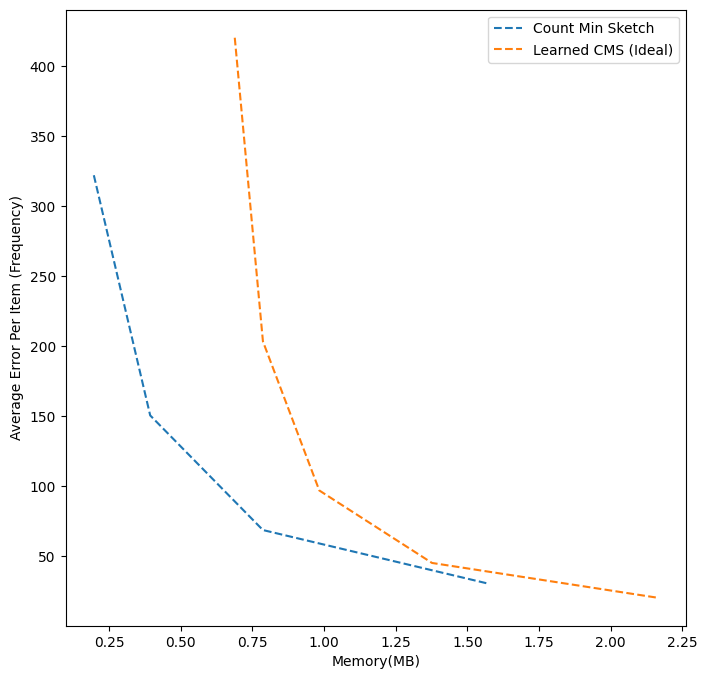

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
# plt.xscale("log")
# plt.yscale("log")
for sketch_data in all_sketches.values():
    plt.plot(sketch_data["memory"], sketch_data["errors"], label = sketch_data["label"], linestyle = sketch_data["plot_linestyle"])
plt.xlabel("Memory(MB)")
plt.ylabel("Average Error Per Item (Frequency)")
plt.legend()
plt.show()